In [1]:
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt

years = [2007,2008,2009,2010,2011,2013,2014,2015,2016] #,2017,2018
year_codes = [2007205,2008205,2009107,2010205,2011206,2013842,2014807,2015837,2016837] #,2017843,2018823
patch_size = 8

for y in tqdm(range(len(years)), desc="Loading Data"):
    var_name = f'patch_data_array_all_{years[y]}'
    globals()[var_name] = np.load(f'/scratch/disk5/ahmet/data/{years[y]}/{year_codes[y]}/'
                                  f'ACOUSTIC/GRIDDED/{year_codes[y]}_patch_data_array_all_{patch_size}w.npy',
                                  allow_pickle=True)
    indices_to_remove = np.where(globals()[var_name]['label'] == 'ignore')[0]
    globals()[var_name] = np.delete(globals()[var_name], indices_to_remove, axis=0)
    globals()[var_name]['total_elements'] = years[y] # Total elements colonuna yil yazdim


Loading Data: 100%|██████████| 9/9 [08:09<00:00, 54.41s/it]


In [2]:
# Concatenation of the Data
data_arrays = []

# Append each data array to the list
for y in range(len(years)):
    var_name = f'patch_data_array_all_{years[y]}'
    data_arrays.append(globals()[var_name])

# Concatenate all arrays into a single array
concatenated_data = np.concatenate(data_arrays, axis=0)
concatenated_data = concatenated_data[~np.isnan(concatenated_data['Sv_all_mean'])]

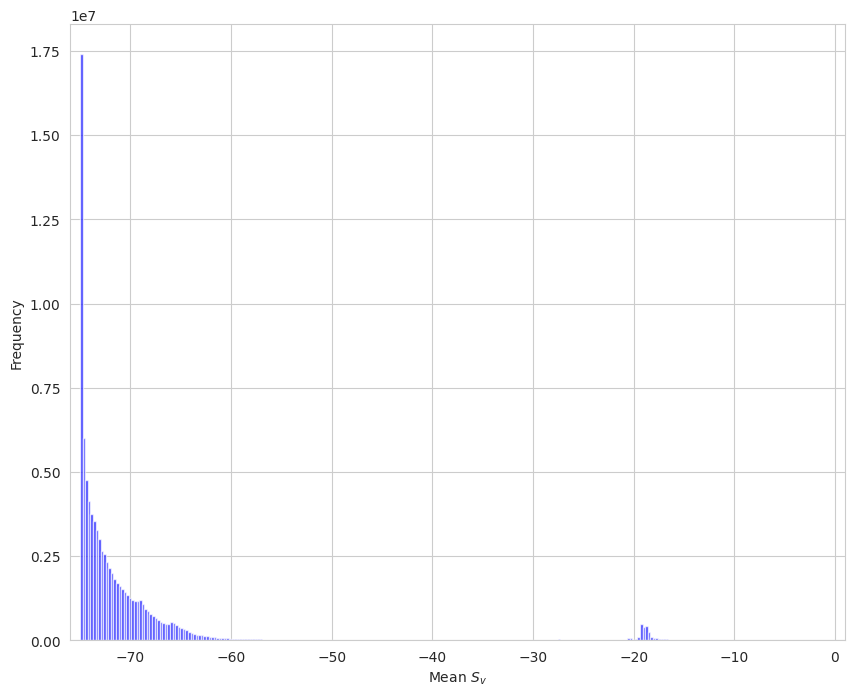

In [3]:
# Visualization: Equal bins (200)
#plt.rcParams["axes.grid"] = False
plt.figure(figsize=(10,8))
# Plot histogram of the average values
plt.hist(concatenated_data['Sv_all_mean'], bins=250, color='blue', alpha=0.7, cumulative=False)
plt.xlabel('Mean $S_v$')
plt.ylabel('Frequency')
plt.xlim(-76, 1)
#plt.savefig('Sv_mean_all_data_equal_bins', dpi=600)
plt.show()

In [4]:
# Clean the data by removing NaN values
clean_data = concatenated_data['Sv_all_mean'][~np.isnan(concatenated_data['Sv_all_mean'])]

# Now calculate the quantile-based bin edges
bin_edges = np.quantile(clean_data, np.linspace(0.1, 0.95, 5))
bin_edges

array([-74.97656892, -74.23381131, -72.81949852, -70.24880473,
       -59.73132642])

In [17]:
borders_95_without_tail = np.linspace(-74.9, np.quantile(clean_data, 0.95),6)
borders_95_without_tail

array([-74.9       , -71.86626528, -68.83253057, -65.79879585,
       -62.76506114, -59.73132642])

In [17]:
borders_95_with_tail = np.append(np.linspace(-74.9, np.quantile(clean_data, 0.95),5), 0)
borders_95_with_tail

array([-74.9       , -71.10783161, -67.31566321, -63.52349482,
       -59.73132642,   0.        ])

In [18]:
import numpy as np

# Assuming concatenated_data is a structured array or a 1D array with dtype that includes 'Sv_all_mean' and 'total_elements'
# Bin edges that you provided
bin_edges = borders_95_with_tail

# Calculate the number of samples per bin
samples_per_bin = 320000 // 5

# Placeholders for the sampled indices
sampled_indices = []

# Iterate over the bins
for i in range(len(bin_edges) - 1):
    # Get the indices of all instances in the current bin
    bin_indices = np.where((concatenated_data['Sv_all_mean'] >= bin_edges[i]) &
                           (concatenated_data['Sv_all_mean'] < bin_edges[i + 1]))[0]

    # Check if there are enough instances in the bin for sampling
    if len(bin_indices) >= samples_per_bin:
        # Randomly choose equal number of samples from each unique element based on 'total_elements'
        unique_elements = np.unique(concatenated_data['total_elements'][bin_indices])
        samples_per_unique = samples_per_bin // len(unique_elements)
        
        # Sample from each unique element
        sampled_bin_indices = []
        for element in unique_elements:
            element_indices = bin_indices[concatenated_data['total_elements'][bin_indices] == element]
            sampled_indices_per_element = np.random.choice(element_indices, size=samples_per_unique, replace=False)
            sampled_bin_indices.extend(sampled_indices_per_element)
    else:
        # If not enough instances, you may need to handle this case separately
        print(f"Not enough samples in bin {i}, needed {samples_per_bin}, but only have {len(bin_indices)}.")
        sampled_bin_indices = bin_indices  # Use all available indices (or handle differently)

    # Append the sampled indices for this bin to the overall list
    sampled_indices.extend(sampled_bin_indices)

# Concatenate all sampled instances into one array
sampled_data = concatenated_data[sampled_indices]

# Verify the size of the sampled data
print(f"Sampled data contains {len(sampled_data)} instances.")


Sampled data contains 319995 instances.


In [19]:
sampled_data = concatenated_data[np.append(sampled_indices,[1,2,3,4,5])]

In [20]:
np.unique(sampled_data['total_elements'],return_counts=True)

(array([2007, 2008, 2009, 2010, 2011, 2013, 2014, 2015, 2016]),
 array([35560, 35555, 35555, 35555, 35555, 35555, 35555, 35555, 35555]))

In [21]:
len(sampled_data)

320000

In [22]:
len(sampled_data[~np.isnan(sampled_data['Sv_all_mean'])])

320000

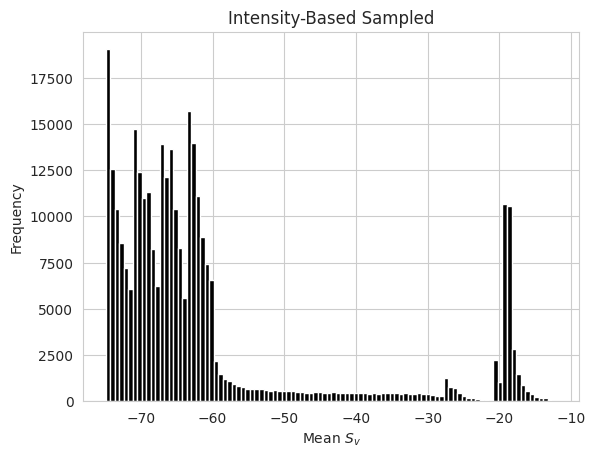

In [23]:
import matplotlib.pyplot as plt

# Plot the histogram for the sampled data on the second subplot
plt.hist(sampled_data['Sv_all_mean'], bins=100, color='black', cumulative=False)
plt.title('Intensity-Based Sampled')
plt.xlabel('Mean $S_v$')
plt.ylabel('Frequency')
#plt.xlim(-76, 1)

plt.show()


In [24]:
np.save('/scratch/disk5/ahmet/data/8w_Sampled_Data_9Years/Intensity_Based4/detailed_8w_IntensityBased4_16Batch_200Ep_100Iter_320000.npy', sampled_data)